In [1]:
# Install PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c133f3585c429c5d1b6e0e17253bcb8d7cf197006eca07aede53c54bb82f729b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# Upload data
from google.colab import files
uploaded = files.upload()

Saving BostonHousing.csv to BostonHousing.csv


In [4]:
# Create a session on Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType

# 1 Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("Lab2").getOrCreate()

In [5]:
# 2 Read 'BostonHousing.csv' dataset in PySpark
df = spark.read.csv('BostonHousing.csv', header=True, inferSchema=True)
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [6]:
# 3 Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv')
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

only_features = ["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "b", "lstat"]
assembler = VectorAssembler(inputCols=only_features, outputCol="features")
feat_df = assembler.transform(df).select('features')
feat_df.show(6)


+--------------------+
|            features|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
|[0.02729,0.0,7.07...|
|[0.03237,0.0,2.18...|
|[0.06905,0.0,2.18...|
|[0.02985,0.0,2.18...|
+--------------------+
only showing top 6 rows



In [7]:
# 4 Standardize features for principal component analysis
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scalerModel = scaler.fit(feat_df)
scaled_df = scalerModel.transform(feat_df)
scaled_df.show(6)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|
+--------------------+--------------------+
only showing top 6 rows



In [9]:
# 5 Train model for two principal component analysis
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(scaled_df)
pca_result = pcaModel.transform(scaled_df)
pca_result.show(6)

+--------------------+--------------------+--------------------+
|            features|      scaledFeatures|         pcaFeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|[2.21266184319277...|
+--------------------+--------------------+--------------------+
only showing top 6 rows



In [10]:
# 6 Collect distributed data in numpy array and then convert to pandas dataframe
import numpy as np
import pandas as pd

pca_array = np.array(pca_result.select("pcaFeatures").rdd.map(lambda x: np.array(x.pcaFeatures)).collect())
pca_df = pd.DataFrame(pca_array, columns=['PCA1', 'PCA2'])
print(pca_df.head())

       PCA1      PCA2
0  2.096223  0.772348
1  1.455811  0.591400
2  2.072547  0.599047
3  2.608922 -0.006864
4  2.455755  0.097615


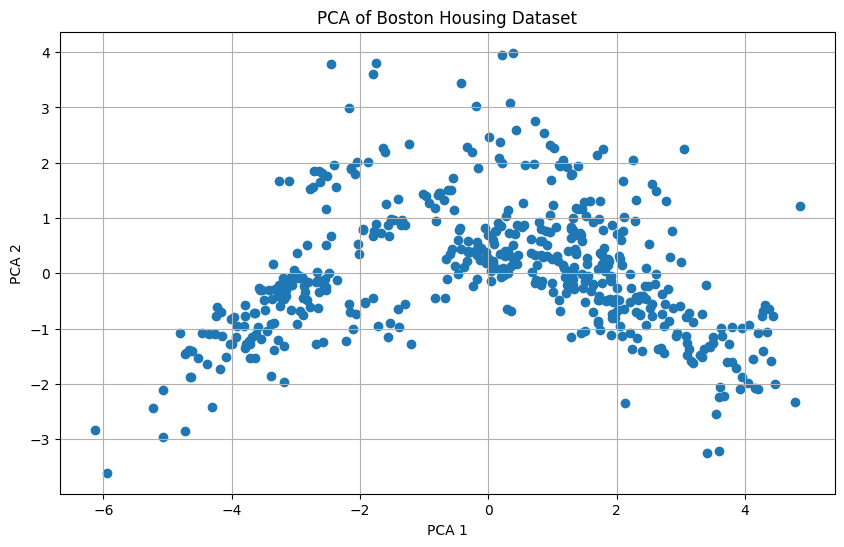

In [11]:
# 7 Plot two principal components
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'])
plt.title('PCA of Boston Housing Dataset')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

In [16]:
# 8 Vectorize features and target together for model development
from pyspark.ml.feature import VectorAssembler

# Include 'medv' along with original features for PCA
assembler_original = VectorAssembler(inputCols=["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "b", "lstat", "medv"],
                                     outputCol="original_features")
feat_df_with_medv = assembler_original.transform(df)

# Perform PCA on the original features including 'medv'
scaler = StandardScaler(inputCol="original_features", outputCol="scaledFeatures", withMean=True, withStd=True)
scalerModel = scaler.fit(feat_df_with_medv)
scaled_df_with_medv = scalerModel.transform(feat_df_with_medv)

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(scaled_df_with_medv)
pca_result_with_medv = pcaModel.transform(scaled_df_with_medv)

# Include PCA features and 'medv' target variable
assembler_final = VectorAssembler(inputCols=["pcaFeatures", "medv"], outputCol="features_with_target")
final_df = assembler_final.transform(pca_result_with_medv)
final_df.select("features_with_target").show(5, truncate=False)

+----------------------------------------------+
|features_with_target                          |
+----------------------------------------------+
|[2.085280250396474,0.4923660417127929,24.0]   |
|[1.3720237591468445,-0.17075479803678975,21.6]|
|[2.3742038250097894,0.9131235404178459,34.7]  |
|[2.834973851170016,0.19467732031534557,33.4]  |
|[2.7701741120707695,0.4328708169029688,36.2]  |
+----------------------------------------------+
only showing top 5 rows



In [20]:
# 9 Split dataset into training and testing dataset

train_df, test_df = final_df.randomSplit([0.8, 0.2])
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 400
Test Dataset Count: 106


In [21]:
# 10 Fit model for linear regression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features_with_target", labelCol="medv")
lr_model = lr.fit(train_df)

In [22]:
# 11 Find out model coefficients and intercept

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [1.204435377633498e-14,2.096393952167354e-14,0.999999999999995]
Intercept: 1.1322718521555365e-13


In [23]:
# 12 Evaluate model for test dataset

test_results = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data: %g" % test_results.rootMeanSquaredError)
print("R-squared (R2) on test data: %g" % test_results.r2)

Root Mean Squared Error (RMSE) on test data: 1.74764e-14
R-squared (R2) on test data: 1


In [24]:
# 13 Perform further analysis for better interpretation of model results.

feature_importance = pd.DataFrame(list(zip(final_df.columns, lr_model.coefficients)), columns=["Feature", "Coefficient"])
print(feature_importance)

  Feature   Coefficient
0    crim  1.204435e-14
1      zn  2.096394e-14
2   indus  1.000000e+00
